In [3]:
# =========================
# CELL 0: Install all required packages
# =========================
#!pip -q install --upgrade "numpy==2.0.2" "pandas==2.2.2" "pillow==11.3.0" "datasets==2.20.0" "pyarrow==16.1.0" "tqdm==4.67.0" "matplotlib==3.8.4" "scikit-learn==1.6.0" "torch==2.3.0" "torchvision==0.18.0"

import numpy as np, pandas as pd, PIL
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("pillow:", PIL.__version__)

numpy: 2.0.2
pandas: 2.2.2
pillow: 11.3.0


In [4]:
# =========================
# CELL 1 (clean): Load dataset
# =========================

import os
from datasets import load_dataset

CACHE_DIR = "/content/hf_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

ds = load_dataset("daniel3303/StoryReasoning", cache_dir=CACHE_DIR)

train_raw = ds["train"]
test_raw  = ds["test"]

print(ds)
print("Train rows:", len(train_raw), "Test rows:", len(test_raw))
print("Columns:", train_raw.column_names)

DatasetDict({
    train: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 3552
    })
    test: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 626
    })
})
Train rows: 3552 Test rows: 626
Columns: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']


In [5]:
# =========================
# CELL 2: Train/Val split + RAM-safe indexing
# =========================
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

all_story_ids = np.array(train_raw["story_id"])
unique_ids = np.unique(all_story_ids)

VAL_FRAC = 0.10
SEED = 42

train_ids, val_ids = train_test_split(unique_ids, test_size=VAL_FRAC, random_state=SEED, shuffle=True)
storyid_to_idx_trainraw = {sid: i for i, sid in enumerate(train_raw["story_id"])}

train_story_indices = [storyid_to_idx_trainraw[sid] for sid in train_ids]
val_story_indices   = [storyid_to_idx_trainraw[sid] for sid in val_ids]

K = 4

def build_index_table(split, story_row_indices, K=4):
    rows = []
    for row_idx in tqdm(story_row_indices, desc="Indexing stories"):
        ex = split[int(row_idx)]
        fc = int(ex["frame_count"])
        if fc < K + 1:
            continue
        for t in range(K, fc):
            rows.append((int(row_idx), int(t), int(fc)))
    return rows

train_index = build_index_table(train_raw, train_story_indices, K=K)
val_index   = build_index_table(train_raw, val_story_indices,   K=K)
test_index  = build_index_table(test_raw, list(range(len(test_raw))), K=K)

print("Train samples:", len(train_index), "Val samples:", len(val_index), "Test samples:", len(test_index))

Indexing stories:   0%|          | 0/3196 [00:00<?, ?it/s]

Indexing stories:   0%|          | 0/356 [00:00<?, ?it/s]

Indexing stories:   0%|          | 0/626 [00:00<?, ?it/s]

Train samples: 27107 Val samples: 2884 Test samples: 5254


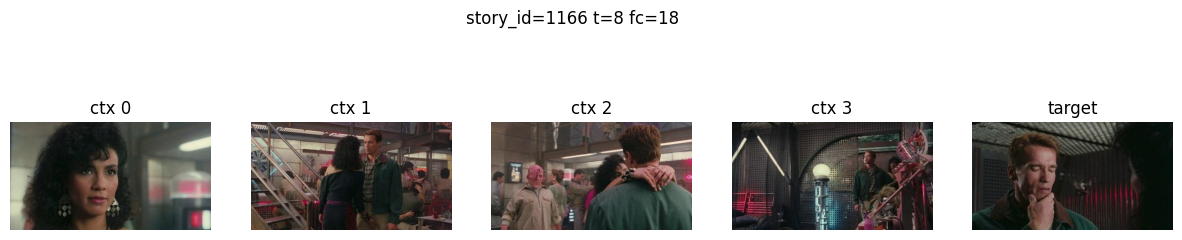

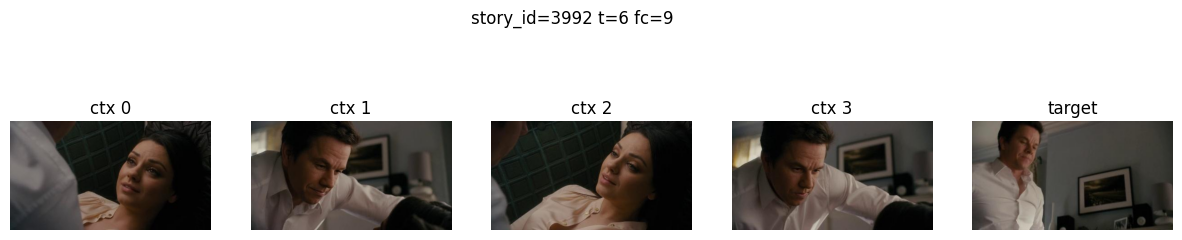

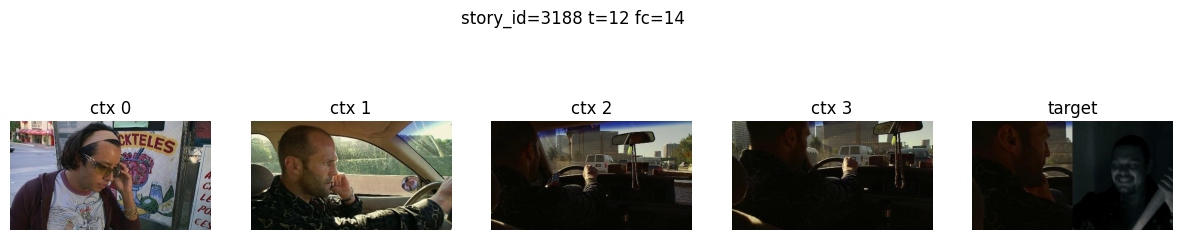

In [6]:
# =========================
# CELL 3: Dataset wrapper for EDA (fetch frames lazily) + quick visualization utilities
# =========================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

class StoryFramesWindowDataset(Dataset):
    def __init__(self, base_split, index_rows, K=4):
        self.base = base_split
        self.index = index_rows
        self.K = K

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        row_idx, t, fc = self.index[i]
        ex = self.base[row_idx]
        imgs = ex["images"]  # list[PIL]
        ctx = imgs[t-self.K:t]
        tgt = imgs[t]
        return {
            "story_id": ex["story_id"],
            "row_idx": row_idx,
            "t_index": t,
            "frame_count": fc,
            "ctx_images": ctx,
            "target_image": tgt,
        }

train_ds = StoryFramesWindowDataset(train_raw, train_index, K=K)
val_ds   = StoryFramesWindowDataset(train_raw, val_index,   K=K)
test_ds  = StoryFramesWindowDataset(test_raw,  test_index,  K=K)

def show_sample(sample, max_ctx=4):
    ctx = sample["ctx_images"][:max_ctx]
    tgt = sample["target_image"]
    n = len(ctx) + 1
    plt.figure(figsize=(3*n, 3))
    for i, im in enumerate(ctx):
        plt.subplot(1, n, i+1)
        plt.imshow(im.convert("RGB"))
        plt.axis("off")
        plt.title(f"ctx {i}")
    plt.subplot(1, n, n)
    plt.imshow(tgt.convert("RGB"))
    plt.axis("off")
    plt.title("target")
    plt.suptitle(f"story_id={sample['story_id']} t={sample['t_index']} fc={sample['frame_count']}", y=1.05)
    plt.show()

# Show a few random samples
import random
for _ in range(3):
    show_sample(train_ds[random.randint(0, len(train_ds)-1)])


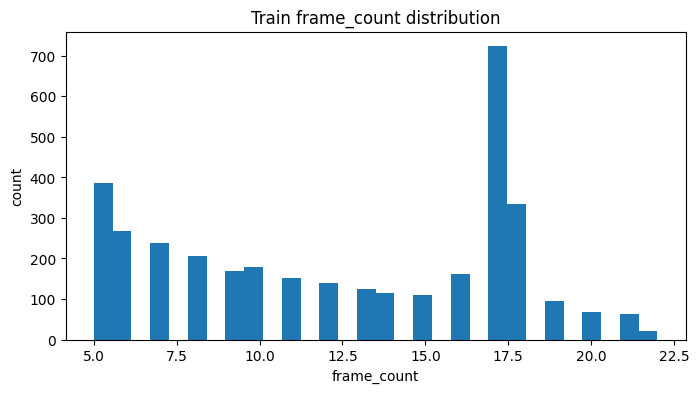

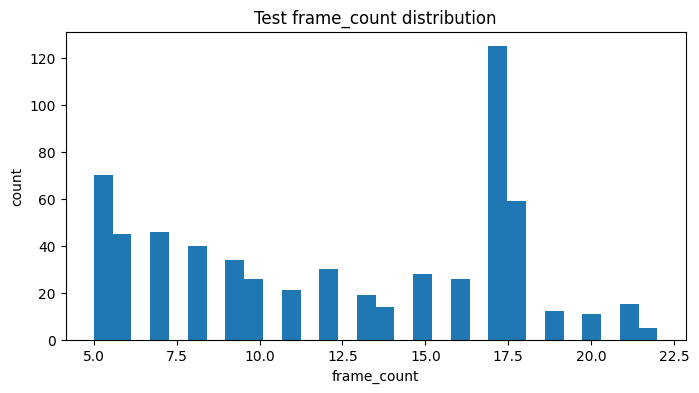

/tmp/ipython-input-3740118589.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fc_train, fc_test], labels=["train", "test"])


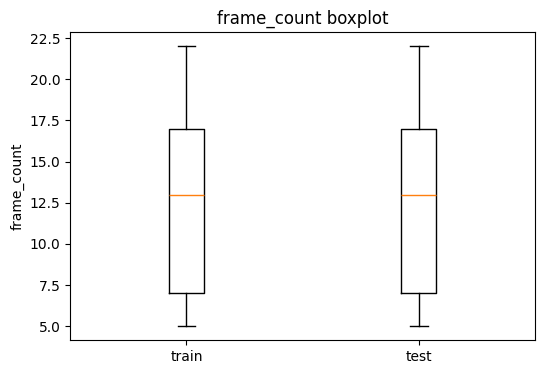

Sampling image sizes:   0%|          | 0/250 [00:00<?, ?it/s]

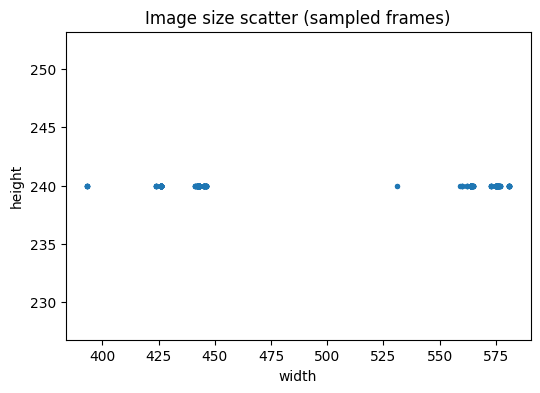

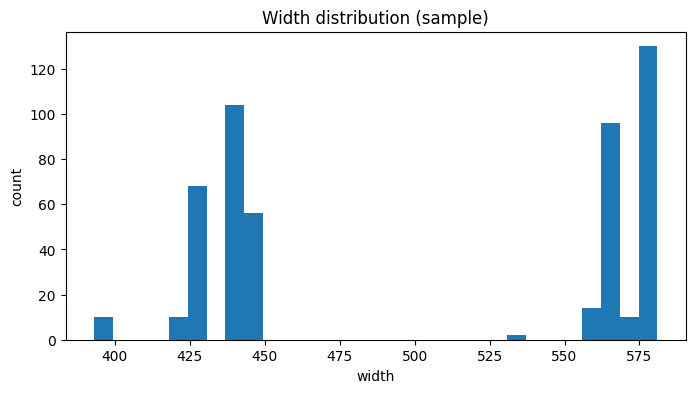

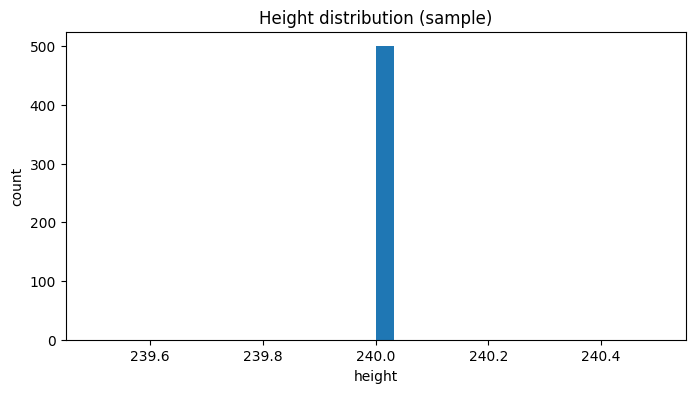

Temporal change (sampled stories):   0%|          | 0/180 [00:00<?, ?it/s]

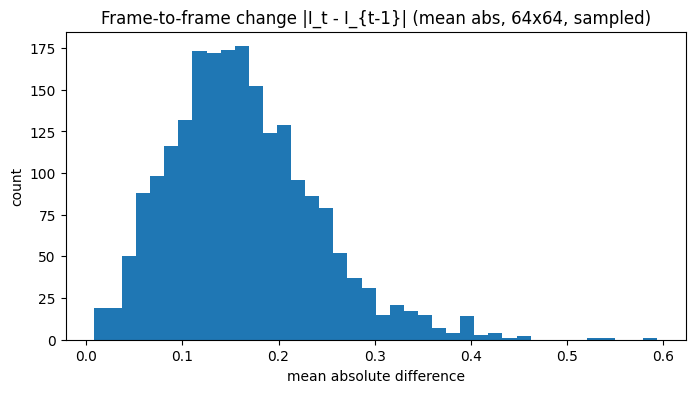

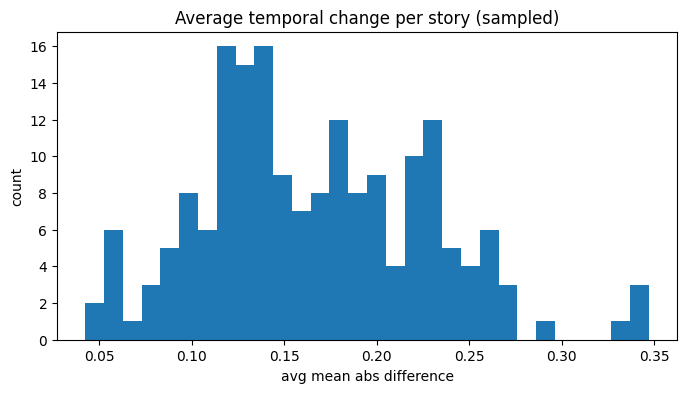

Temporal change vs frame_count:   0%|          | 0/160 [00:00<?, ?it/s]

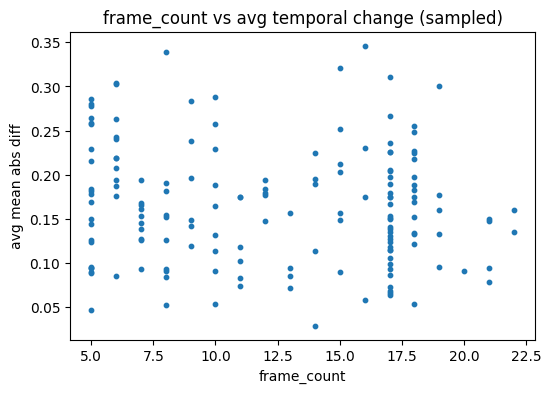

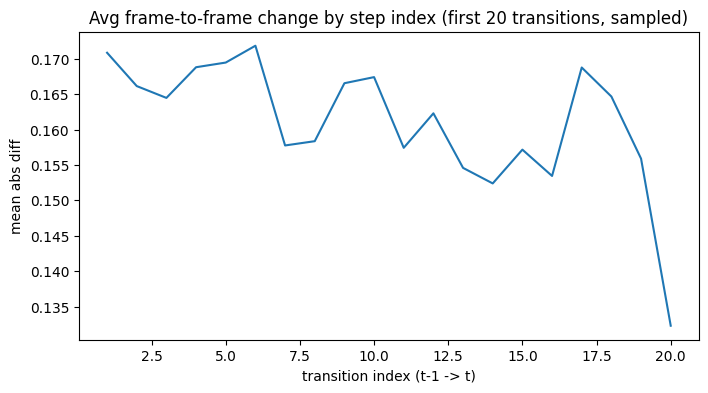

EDA complete.


In [7]:
# =========================
# CELL 4: EDA - frame_count distribution + image size distribution + temporal change stats
# =========================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ---- 4.1 frame_count histograms (train/test) ----
fc_train = np.array(train_raw["frame_count"])
fc_test  = np.array(test_raw["frame_count"])

plt.figure(figsize=(8,4))
plt.hist(fc_train, bins=30)
plt.title("Train frame_count distribution")
plt.xlabel("frame_count")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(fc_test, bins=30)
plt.title("Test frame_count distribution")
plt.xlabel("frame_count")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot([fc_train, fc_test], labels=["train", "test"])
plt.title("frame_count boxplot")
plt.ylabel("frame_count")
plt.show()

# ---- 4.2 image size distribution (sample stories) ----
def sample_image_sizes(split, n_stories=200, seed=0):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(np.arange(len(split)), size=min(n_stories, len(split)), replace=False)
    ws, hs = [], []
    for i in tqdm(idxs, desc="Sampling image sizes"):
        ex = split[int(i)]
        imgs = ex["images"]
        # sample first and last frame to reduce cost
        for im in [imgs[0], imgs[-1]]:
            w, h = im.size
            ws.append(w); hs.append(h)
    return np.array(ws), np.array(hs)

ws, hs = sample_image_sizes(train_raw, n_stories=250, seed=1)

plt.figure(figsize=(6,4))
plt.scatter(ws, hs, s=8)
plt.title("Image size scatter (sampled frames)")
plt.xlabel("width")
plt.ylabel("height")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(ws, bins=30)
plt.title("Width distribution (sample)")
plt.xlabel("width")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(hs, bins=30)
plt.title("Height distribution (sample)")
plt.xlabel("height")
plt.ylabel("count")
plt.show()

# ---- 4.3 temporal change stats: mean absolute difference between consecutive frames ----
# Compute on resized small images for speed (64x64)
from PIL import Image

def img_to_small_array(im, size=64):
    im = im.convert("RGB").resize((size, size))
    arr = np.asarray(im, dtype=np.float32) / 255.0
    return arr

def temporal_change_stats(split, n_stories=150, size=64, seed=0):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(np.arange(len(split)), size=min(n_stories, len(split)), replace=False)

    per_story_avg = []
    per_pair_changes = []
    # track change by relative frame index (to plot average curve)
    curves = []

    for i in tqdm(idxs, desc="Temporal change (sampled stories)"):
        ex = split[int(i)]
        imgs = ex["images"]
        fc = len(imgs)
        if fc < 2:
            continue
        diffs = []
        for t in range(1, fc):
            a = img_to_small_array(imgs[t-1], size=size)
            b = img_to_small_array(imgs[t], size=size)
            d = np.mean(np.abs(b - a))
            diffs.append(d)
            per_pair_changes.append(d)
        if diffs:
            per_story_avg.append(float(np.mean(diffs)))
            curves.append(diffs)

    return np.array(per_story_avg), np.array(per_pair_changes), curves

story_avg, pair_changes, curves = temporal_change_stats(train_raw, n_stories=180, size=64, seed=2)

plt.figure(figsize=(8,4))
plt.hist(pair_changes, bins=40)
plt.title("Frame-to-frame change |I_t - I_{t-1}| (mean abs, 64x64, sampled)")
plt.xlabel("mean absolute difference")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(story_avg, bins=30)
plt.title("Average temporal change per story (sampled)")
plt.xlabel("avg mean abs difference")
plt.ylabel("count")
plt.show()

# Scatter: frame_count vs avg change (sampled stories)
# Need the frame_count for the sampled stories. Re-run quickly alongside:
def temporal_change_with_fc(split, n_stories=150, size=64, seed=0):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(np.arange(len(split)), size=min(n_stories, len(split)), replace=False)
    xs_fc, ys_avg = [], []
    for i in tqdm(idxs, desc="Temporal change vs frame_count"):
        ex = split[int(i)]
        imgs = ex["images"]
        fc = len(imgs)
        if fc < 2:
            continue
        diffs = []
        for t in range(1, fc):
            a = img_to_small_array(imgs[t-1], size=size)
            b = img_to_small_array(imgs[t], size=size)
            diffs.append(np.mean(np.abs(b - a)))
        xs_fc.append(fc)
        ys_avg.append(float(np.mean(diffs)))
    return np.array(xs_fc), np.array(ys_avg)

xs_fc, ys_avg = temporal_change_with_fc(train_raw, n_stories=160, size=64, seed=3)

plt.figure(figsize=(6,4))
plt.scatter(xs_fc, ys_avg, s=10)
plt.title("frame_count vs avg temporal change (sampled)")
plt.xlabel("frame_count")
plt.ylabel("avg mean abs diff")
plt.show()

# Average temporal change curve across normalized time (rough)
# Pad/truncate to a fixed max_len for plotting mean curve
MAX_LEN = 20
mat = np.full((len(curves), MAX_LEN), np.nan, dtype=np.float32)
for i, diffs in enumerate(curves):
    L = min(len(diffs), MAX_LEN)
    mat[i, :L] = diffs[:L]

mean_curve = np.nanmean(mat, axis=0)
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_LEN+1), mean_curve)
plt.title("Avg frame-to-frame change by step index (first 20 transitions, sampled)")
plt.xlabel("transition index (t-1 -> t)")
plt.ylabel("mean abs diff")
plt.show()

print("EDA complete.")


In [8]:
import PIL

print("pillow:", PIL.__version__)

pillow: 11.3.0


In [9]:
# =========================
# CELL 5: Image preprocessing for diffusion (128x128, [-1,1])
# =========================

import torch
from torchvision import transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 128

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),              # [0,1]
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )                                   # -> [-1,1]
])

def preprocess_pil(im):
    return img_transform(im.convert("RGB"))

In [10]:
# =========================
# CELL 6: Dataset for temporal prediction (image-only)
# =========================

from torch.utils.data import Dataset

class TemporalImageDataset(Dataset):
    def __init__(self, base_split, index_rows, K=4):
        self.base = base_split
        self.index = index_rows
        self.K = K

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        row_idx, t, fc = self.index[i]
        ex = self.base[row_idx]
        imgs = ex["images"]

        ctx_imgs = imgs[t-self.K:t]
        tgt_img  = imgs[t]

        ctx = torch.stack([preprocess_pil(im) for im in ctx_imgs], dim=0)   # [K,3,H,W]
        tgt = preprocess_pil(tgt_img)                                       # [3,H,W]

        return {
            "ctx_images": ctx,
            "target_image": tgt,
            "story_id": ex["story_id"],
            "t_index": t,
        }

train_img_ds = TemporalImageDataset(train_raw, train_index, K=K)
val_img_ds   = TemporalImageDataset(train_raw, val_index,   K=K)
test_img_ds  = TemporalImageDataset(test_raw,  test_index,  K=K)

print("Train:", len(train_img_ds), "Val:", len(val_img_ds), "Test:", len(test_img_ds))

Train: 27107 Val: 2884 Test: 5254


In [11]:
# =========================
# SANITY CHECK: shapes + value range
# =========================

sample = train_img_ds[0]
print("ctx shape:", sample["ctx_images"].shape)
print("tgt shape:", sample["target_image"].shape)
print("value range:", sample["target_image"].min().item(), sample["target_image"].max().item())

ctx shape: torch.Size([4, 3, 128, 128])
tgt shape: torch.Size([3, 128, 128])
value range: -0.8823529481887817 0.9921568632125854


In [12]:
# =========================
# CELL 7: DataLoaders + Baseline model (Conv encoder + GRU + Conv decoder) + Train/Val loop
# Baseline (image-only next-frame prediction)
# - Input: ctx_images [B,K,3,128,128]
# - Output: predicted next frame [B,3,128,128] in [-1,1]
# - Loss: L1 + optional SSIM-style regularizer (kept simple)
# - Metrics: L1, MSE, PSNR, temporal consistency vs last context frame
# =========================

!pip -q install "tqdm==4.66.4"

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
K = 4
IMG_SIZE = 128

BATCH_SIZE = 16  # if OOM, set 8
NUM_WORKERS = 2  # if any dataloader issues, set 0

train_loader = DataLoader(train_img_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_img_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---- Utils ----
def psnr_from_mse(mse):
    # images are in [-1,1], so peak-to-peak range is 2 => peak value = 2
    # PSNR = 20*log10(peak) - 10*log10(mse)
    return 20.0 * math.log10(2.0) - 10.0 * math.log10(max(mse, 1e-12))

@torch.no_grad()
def temporal_consistency(pred, ctx_last, tgt):
    # Compare predicted change vs true change relative to last context frame
    # TC1: mean absolute difference to last frame (lower can be "smoother", but can also mean under-moving)
    tc1_pred = (pred - ctx_last).abs().mean().item()
    tc1_true = (tgt  - ctx_last).abs().mean().item()
    # TC2: difference-of-differences (how well predicted motion matches true motion)
    tc2 = ((pred - ctx_last) - (tgt - ctx_last)).abs().mean().item()
    return tc1_pred, tc1_true, tc2

# ---- Model ----
class FrameEncoder(nn.Module):
    def __init__(self, emb_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),           # 64x64
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),         # 32x32
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),        # 16x16
            nn.Conv2d(256, 256, 4, 2, 1), nn.ReLU(),        # 8x8
            nn.AdaptiveAvgPool2d((1,1)),                    # 1x1
        )
        self.proj = nn.Linear(256, emb_dim)

    def forward(self, x):
        # x: [B,3,H,W]
        h = self.net(x).flatten(1)     # [B,256]
        return self.proj(h)            # [B,emb_dim]

class FrameDecoder(nn.Module):
    def __init__(self, emb_dim=256):
        super().__init__()
        self.fc = nn.Linear(emb_dim, 256*8*8)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1), nn.ReLU(),  # 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),  # 32x32
            nn.ConvTranspose2d(128, 64,  4, 2, 1), nn.ReLU(),  # 64x64
            nn.ConvTranspose2d(64,  32,  4, 2, 1), nn.ReLU(),  # 128x128
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh()  # keep output in [-1,1]
        )

    def forward(self, z):
        # z: [B,emb_dim]
        h = self.fc(z).view(z.size(0), 256, 8, 8)
        return self.net(h)

class GRUNextFrameBaseline(nn.Module):
    def __init__(self, emb_dim=256, hidden_dim=256):
        super().__init__()
        self.enc = FrameEncoder(emb_dim=emb_dim)
        self.gru = nn.GRU(input_size=emb_dim, hidden_size=hidden_dim, batch_first=True)
        self.to_latent = nn.Linear(hidden_dim, emb_dim)
        self.dec = FrameDecoder(emb_dim=emb_dim)

    def forward(self, ctx):
        # ctx: [B,K,3,H,W]
        B, K, C, H, W = ctx.shape
        ctx_flat = ctx.view(B*K, C, H, W)
        emb = self.enc(ctx_flat).view(B, K, -1)   # [B,K,E]
        _, hN = self.gru(emb)                     # [1,B,H]
        h = hN.squeeze(0)                         # [B,H]
        z = self.to_latent(h)                     # [B,E]
        pred = self.dec(z)                        # [B,3,H,W]
        return pred

model = GRUNextFrameBaseline(emb_dim=256, hidden_dim=256).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# ---- Train/Eval ----
def run_epoch(loader, train=True, desc="train"):
    model.train(train)
    tot = 0
    sum_l1 = 0.0
    sum_mse = 0.0
    sum_tc2 = 0.0

    pbar = tqdm(loader, desc=desc, leave=False)
    for batch in pbar:
        ctx = batch["ctx_images"].to(DEVICE, non_blocking=True)      # [B,K,3,128,128]
        tgt = batch["target_image"].to(DEVICE, non_blocking=True)    # [B,3,128,128]
        ctx_last = ctx[:, -1]                                        # [B,3,128,128]

        pred = model(ctx)

        l1 = F.l1_loss(pred, tgt)
        mse = F.mse_loss(pred, tgt)
        loss = l1 + 0.1 * mse

        if train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        with torch.no_grad():
            tc1_pred, tc1_true, tc2 = temporal_consistency(pred, ctx_last, tgt)

        bs = ctx.size(0)
        tot += bs
        sum_l1 += l1.item() * bs
        sum_mse += mse.item() * bs
        sum_tc2 += tc2 * bs

        pbar.set_postfix({"l1": sum_l1/tot, "mse": sum_mse/tot, "tc2": sum_tc2/tot})

    avg_l1 = sum_l1 / max(tot, 1)
    avg_mse = sum_mse / max(tot, 1)
    avg_psnr = psnr_from_mse(avg_mse)
    avg_tc2 = sum_tc2 / max(tot, 1)
    return {"l1": avg_l1, "mse": avg_mse, "psnr": avg_psnr, "tc2": avg_tc2}

EPOCHS = 2
best_val = 1e9

for epoch in range(1, EPOCHS + 1):
    tr = run_epoch(train_loader, train=True,  desc=f"train epoch {epoch}")
    va = run_epoch(val_loader,   train=False, desc=f"val epoch {epoch}")

    print(f"\nEpoch {epoch}")
    print(f"  train: l1={tr['l1']:.4f} mse={tr['mse']:.4f} psnr={tr['psnr']:.2f} tc2={tr['tc2']:.4f}")
    print(f"  val:   l1={va['l1']:.4f} mse={va['mse']:.4f} psnr={va['psnr']:.2f} tc2={va['tc2']:.4f}")

    # Save best checkpoint (by val l1)
    if va["l1"] < best_val:
        best_val = va["l1"]
        torch.save(
            {"epoch": epoch, "model_state": model.state_dict(), "opt_state": opt.state_dict(), "val": va},
            "/content/baseline_best.pt"
        )
        print("  saved /content/baseline_best.pt")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires tqdm>=4.67, but you have tqdm 4.66.4 which is incompatible.


train epoch 1:   0%|          | 0/1695 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


val epoch 1:   0%|          | 0/181 [00:00<?, ?it/s]


Epoch 1
  train: l1=0.3126 mse=0.1892 psnr=13.25 tc2=0.3126
  val:   l1=0.3108 mse=0.1721 psnr=13.66 tc2=0.3108
  saved /content/baseline_best.pt


train epoch 2:   0%|          | 0/1695 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd52d2feac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bd52d2feac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

val epoch 2:   0%|          | 0/181 [00:00<?, ?it/s]


Epoch 2
  train: l1=0.3037 mse=0.1794 psnr=13.48 tc2=0.3037
  val:   l1=0.3081 mse=0.1977 psnr=13.06 tc2=0.3081
  saved /content/baseline_best.pt


In [13]:
# =========================
# CELL 8: Fix DataLoader worker shutdown issue + Qualitative results grid
# - Rebuild loaders with num_workers=0 (Colab multiprocessing bug workaround)
# - Load best baseline checkpoint
# - Save grids: [4 context frames | GT next | Pred next]
# - Also compute quick val metrics on a small subset for sanity
# =========================

import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "/content/project2_baseline_qual"
os.makedirs(OUT_DIR, exist_ok=True)

# Rebuild loaders safely (no multiprocessing)
BATCH_SIZE = 8
train_loader0 = DataLoader(train_img_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader0   = DataLoader(val_img_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---- Reload model definition if it is still in memory; otherwise re-run Cell 7 model classes ----
# Here we assume `GRUNextFrameBaseline` exists and matches the saved checkpoint.
model = GRUNextFrameBaseline(emb_dim=256, hidden_dim=256).to(DEVICE)

ckpt = torch.load("/content/baseline_best.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()
print("Loaded baseline_best.pt from epoch:", ckpt.get("epoch", "unknown"))

# ---- Helpers: denorm [-1,1] -> [0,1] for plotting ----
@torch.no_grad()
def to_img01(x):
    return (x.clamp(-1, 1) + 1) / 2.0

@torch.no_grad()
def save_grid(sample, pred, out_path):
    # sample: dict from dataset (single item), pred: [3,H,W]
    ctx = sample["ctx_images"]          # [K,3,H,W]
    tgt = sample["target_image"]        # [3,H,W]
    K = ctx.shape[0]

    ctx01 = to_img01(ctx)
    tgt01 = to_img01(tgt)
    pred01 = to_img01(pred)

    n = K + 2
    plt.figure(figsize=(3*n, 3))
    for i in range(K):
        plt.subplot(1, n, i+1)
        plt.imshow(ctx01[i].permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.title(f"ctx {i}")

    plt.subplot(1, n, K+1)
    plt.imshow(tgt01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("GT next")

    plt.subplot(1, n, K+2)
    plt.imshow(pred01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("Pred next")

    plt.tight_layout()
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close()

# ---- 1) Save qualitative grids for N random validation samples ----
import random
N_SAMPLES = 25
idxs = [random.randint(0, len(val_img_ds)-1) for _ in range(N_SAMPLES)]

for j, idx in enumerate(tqdm(idxs, desc="Saving qualitative grids")):
    sample = val_img_ds[idx]
    ctx = sample["ctx_images"].unsqueeze(0).to(DEVICE)  # [1,K,3,H,W]
    with torch.no_grad():
        pred = model(ctx)[0].detach().cpu()             # [3,H,W]
    out_path = os.path.join(OUT_DIR, f"val_sample_{j:03d}.png")
    save_grid(sample, pred, out_path)

print("Saved qualitative grids to:", OUT_DIR)

# ---- 2) Quick metric eval on a small subset (optional, fast) ----
import torch.nn.functional as F
import math

def psnr_from_mse(mse):
    return 20.0 * math.log10(2.0) - 10.0 * math.log10(max(mse, 1e-12))

@torch.no_grad()
def temporal_consistency(pred, ctx_last, tgt):
    tc2 = ((pred - ctx_last) - (tgt - ctx_last)).abs().mean().item()
    return tc2

SUBSET_BATCHES = 60  # ~60 batches * 8 = 480 samples
tot = 0
sum_l1 = 0.0
sum_mse = 0.0
sum_tc2 = 0.0

for b_i, batch in enumerate(tqdm(val_loader0, desc="Quick val eval", leave=False)):
    if b_i >= SUBSET_BATCHES:
        break
    ctx = batch["ctx_images"].to(DEVICE)
    tgt = batch["target_image"].to(DEVICE)
    ctx_last = ctx[:, -1]

    pred = model(ctx)

    l1 = F.l1_loss(pred, tgt).item()
    mse = F.mse_loss(pred, tgt).item()
    tc2 = temporal_consistency(pred, ctx_last, tgt)

    bs = ctx.size(0)
    tot += bs
    sum_l1 += l1 * bs
    sum_mse += mse * bs
    sum_tc2 += tc2 * bs

avg_l1 = sum_l1 / max(tot, 1)
avg_mse = sum_mse / max(tot, 1)
avg_psnr = psnr_from_mse(avg_mse)
avg_tc2 = sum_tc2 / max(tot, 1)

print("\nQuick Val Metrics (subset):")
print(f"  l1={avg_l1:.4f} mse={avg_mse:.4f} psnr={avg_psnr:.2f} tc2={avg_tc2:.4f}")


Loaded baseline_best.pt from epoch: 2


Saving qualitative grids:   0%|          | 0/25 [00:00<?, ?it/s]

Saved qualitative grids to: /content/project2_baseline_qual


Quick val eval:   0%|          | 0/361 [00:00<?, ?it/s]


Quick Val Metrics (subset):
  l1=0.3248 mse=0.2163 psnr=12.67 tc2=0.3248


In [14]:
# =========================
# CELL 9: Diffusion model (conditional on past K frames) - training + val loss
# Project 2 main model
#
# What you get:
# - Cosine/linear beta schedule (cosine-like simplified here)
# - T=100 diffusion steps
# - UNet-lite denoiser predicts noise eps
# - Conditioning from context frames via CNN encoder + GRU
# - Train loop with tqdm + checkpoint saving
#
# Output:
# - /content/diffusion_best.pt
# - prints train/val noise-MSE each epoch
# =========================

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 128
K = 4
T_STEPS = 100

BATCH_SIZE = 16  # if OOM set 8
train_loader = DataLoader(train_img_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_img_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -------------------------
# 1) Diffusion schedule
# -------------------------
def cosine_beta_schedule(T, s=0.008):
    # from Nichol & Dhariwal (improved DDPM), common schedule
    steps = torch.arange(T + 1, dtype=torch.float32)
    f = torch.cos(((steps / T) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_bar = f / f[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return betas.clamp(1e-5, 0.999)

betas = cosine_beta_schedule(T_STEPS).to(DEVICE)                 # [T]
alphas = (1.0 - betas)                                           # [T]
alphas_bar = torch.cumprod(alphas, dim=0)                        # [T]
sqrt_ab = torch.sqrt(alphas_bar)                                 # [T]
sqrt_1mab = torch.sqrt(1.0 - alphas_bar)                         # [T]

def extract(a, t, xshape):
    # a: [T], t: [B] int64
    out = a.gather(0, t).view(-1, 1, 1, 1)
    return out.expand(xshape)

# -------------------------
# 2) Time embedding
# -------------------------
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        # t: [B] in [0..T-1]
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device).float() / (half - 1))
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb  # [B, dim]

# -------------------------
# 3) Conditioning encoder: CNN per frame + GRU aggregate -> cond vector
# -------------------------
class CondEncoder(nn.Module):
    def __init__(self, cond_dim=256):
        super().__init__()
        self.frame_cnn = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),   # 64
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),  # 32
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(), # 16
            nn.Conv2d(128, 128, 4, 2, 1), nn.ReLU(),# 8
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.proj = nn.Linear(128, cond_dim)
        self.gru = nn.GRU(input_size=cond_dim, hidden_size=cond_dim, batch_first=True)

    def forward(self, ctx):
        # ctx: [B,K,3,H,W]
        B, K, C, H, W = ctx.shape
        x = ctx.view(B*K, C, H, W)
        h = self.frame_cnn(x).flatten(1)   # [B*K,128]
        e = self.proj(h).view(B, K, -1)    # [B,K,cond_dim]
        _, hN = self.gru(e)                # [1,B,cond_dim]
        return hN.squeeze(0)               # [B,cond_dim]

# -------------------------
# 4) UNet-lite with FiLM conditioning
# -------------------------
class FiLM(nn.Module):
    def __init__(self, in_dim, out_channels):
        super().__init__()
        self.to_scale = nn.Linear(in_dim, out_channels)
        self.to_shift = nn.Linear(in_dim, out_channels)

    def forward(self, x, cond):
        # x: [B,C,H,W], cond: [B,D]
        scale = self.to_scale(cond).view(cond.size(0), -1, 1, 1)
        shift = self.to_shift(cond).view(cond.size(0), -1, 1, 1)
        return x * (1 + scale) + shift

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.emb = nn.Linear(emb_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb):
        h = F.relu(self.conv1(x))
        h = h + self.emb(emb).view(emb.size(0), -1, 1, 1)
        h = F.relu(self.conv2(h))
        return h + self.skip(x)

class UNetLite(nn.Module):
    def __init__(self, emb_dim=256, base=64):
        super().__init__()
        self.down1 = ResBlock(3, base, emb_dim)
        self.down2 = ResBlock(base, base*2, emb_dim)
        self.down3 = ResBlock(base*2, base*4, emb_dim)

        self.pool = nn.AvgPool2d(2)

        self.mid  = ResBlock(base*4, base*4, emb_dim)

        self.up3 = ResBlock(base*4 + base*4, base*2, emb_dim)
        self.up2 = ResBlock(base*2 + base*2, base, emb_dim)
        self.up1 = ResBlock(base + base, base, emb_dim)

        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.out = nn.Conv2d(base, 3, 1)

    def forward(self, x, emb):
        # Down
        d1 = self.down1(x, emb)        # 128
        x  = self.pool(d1)             # 64
        d2 = self.down2(x, emb)        # 64
        x  = self.pool(d2)             # 32
        d3 = self.down3(x, emb)        # 32
        x  = self.pool(d3)             # 16

        # Mid
        m  = self.mid(x, emb)          # 16

        # Up
        x = self.up(m)                 # 32
        x = torch.cat([x, d3], dim=1)
        x = self.up3(x, emb)

        x = self.up(x)                 # 64
        x = torch.cat([x, d2], dim=1)
        x = self.up2(x, emb)

        x = self.up(x)                 # 128
        x = torch.cat([x, d1], dim=1)
        x = self.up1(x, emb)

        return self.out(x)             # noise prediction eps_hat

# -------------------------
# 5) Full diffusion model wrapper
# -------------------------
class ConditionalDiffusion(nn.Module):
    def __init__(self, cond_dim=256, time_dim=256):
        super().__init__()
        self.cond_enc = CondEncoder(cond_dim=cond_dim)
        self.t_embed = SinusoidalTimeEmbedding(time_dim)
        self.emb_mlp = nn.Sequential(
            nn.Linear(cond_dim + time_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
        )
        self.unet = UNetLite(emb_dim=256, base=64)

    def forward(self, x_t, t, ctx):
        # ctx -> cond vector
        c = self.cond_enc(ctx)        # [B,cond_dim]
        te = self.t_embed(t)          # [B,time_dim]
        emb = self.emb_mlp(torch.cat([c, te], dim=1))  # [B,256]
        return self.unet(x_t, emb)

diff_model = ConditionalDiffusion(cond_dim=256, time_dim=256).to(DEVICE)
opt = torch.optim.AdamW(diff_model.parameters(), lr=2e-4, weight_decay=0.01)

# -------------------------
# 6) Train/Val (noise prediction)
# -------------------------
def train_epoch(loader, epoch):
    diff_model.train()
    tot = 0
    sum_loss = 0.0
    pbar = tqdm(loader, desc=f"diff train {epoch}", leave=False)
    for batch in pbar:
        ctx = batch["ctx_images"].to(DEVICE)
        x0  = batch["target_image"].to(DEVICE)

        B = x0.size(0)
        t = torch.randint(0, T_STEPS, (B,), device=DEVICE, dtype=torch.long)
        eps = torch.randn_like(x0)

        x_t = extract(sqrt_ab, t, x0.shape) * x0 + extract(sqrt_1mab, t, x0.shape) * eps
        eps_hat = diff_model(x_t, t, ctx)

        loss = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(diff_model.parameters(), 1.0)
        opt.step()

        bs = B
        tot += bs
        sum_loss += loss.item() * bs
        pbar.set_postfix({"mse_eps": sum_loss/tot})

    return {"mse_eps": sum_loss / max(tot, 1)}

@torch.no_grad()
def eval_epoch(loader, epoch, max_batches=120):
    diff_model.eval()
    tot = 0
    sum_loss = 0.0
    pbar = tqdm(loader, desc=f"diff val {epoch}", leave=False)
    for i, batch in enumerate(pbar):
        if i >= max_batches:
            break
        ctx = batch["ctx_images"].to(DEVICE)
        x0  = batch["target_image"].to(DEVICE)

        B = x0.size(0)
        t = torch.randint(0, T_STEPS, (B,), device=DEVICE, dtype=torch.long)
        eps = torch.randn_like(x0)

        x_t = extract(sqrt_ab, t, x0.shape) * x0 + extract(sqrt_1mab, t, x0.shape) * eps
        eps_hat = diff_model(x_t, t, ctx)

        loss = F.mse_loss(eps_hat, eps)

        tot += B
        sum_loss += loss.item() * B
        pbar.set_postfix({"mse_eps": sum_loss/tot})

    return {"mse_eps": sum_loss / max(tot, 1)}

EPOCHS = 3
best_val = 1e9
SAVE_PATH = "/content/diffusion_best.pt"

for epoch in range(1, EPOCHS + 1):
    tr = train_epoch(train_loader, epoch)
    va = eval_epoch(val_loader, epoch)

    print(f"\nEpoch {epoch} (diffusion noise-pred)")
    print(f"  train mse_eps={tr['mse_eps']:.6f}")
    print(f"  val   mse_eps={va['mse_eps']:.6f}")

    # save best by val noise-MSE
    if va["mse_eps"] < best_val:
        best_val = va["mse_eps"]
        torch.save(
            {"epoch": epoch, "model_state": diff_model.state_dict(), "opt_state": opt.state_dict(), "val": va,
             "T_STEPS": T_STEPS, "IMG_SIZE": IMG_SIZE, "K": K},
            SAVE_PATH
        )
        print("  saved", SAVE_PATH)


diff train 1:   0%|          | 0/1695 [00:00<?, ?it/s]

diff val 1:   0%|          | 0/181 [00:00<?, ?it/s]


Epoch 1 (diffusion noise-pred)
  train mse_eps=0.061095
  val   mse_eps=0.034996
  saved /content/diffusion_best.pt


diff train 2:   0%|          | 0/1695 [00:00<?, ?it/s]

diff val 2:   0%|          | 0/181 [00:00<?, ?it/s]


Epoch 2 (diffusion noise-pred)
  train mse_eps=0.030177
  val   mse_eps=0.028697
  saved /content/diffusion_best.pt


diff train 3:   0%|          | 0/1695 [00:00<?, ?it/s]

diff val 3:   0%|          | 0/181 [00:00<?, ?it/s]


Epoch 3 (diffusion noise-pred)
  train mse_eps=0.027186
  val   mse_eps=0.030016


In [15]:
# =========================
# CELL 10: Diffusion sampling + quantitative evaluation vs GT + qualitative grids
# - Loads /content/diffusion_best.pt
# - Generates x0_hat via reverse diffusion (DDPM sampling)
# - Computes: L1, MSE, PSNR, TC2 (motion match) on a validation subset
# - Saves grids: [4 ctx | GT next | Diffusion pred]
#
# Notes:
# - Sampling is slower than baseline; keep N small.
# - Uses 100 steps reverse diffusion (T_STEPS) from checkpoint.
# =========================

import os, math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "/content/project2_diffusion_qual"
os.makedirs(OUT_DIR, exist_ok=True)

# Safe loader (no multiprocessing)
BATCH_SIZE = 8
val_loader0 = DataLoader(val_img_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---- Load best diffusion checkpoint ----
ckpt = torch.load("/content/diffusion_best.pt", map_location=DEVICE)
T_STEPS = int(ckpt.get("T_STEPS", 100))

diff_model = ConditionalDiffusion(cond_dim=256, time_dim=256).to(DEVICE)
diff_model.load_state_dict(ckpt["model_state"])
diff_model.eval()
print("Loaded diffusion_best.pt from epoch:", ckpt.get("epoch", "unknown"), "T_STEPS:", T_STEPS)

# ---- Rebuild schedule tensors on DEVICE (must match training schedule) ----
def cosine_beta_schedule(T, s=0.008):
    steps = torch.arange(T + 1, dtype=torch.float32)
    f = torch.cos(((steps / T) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_bar = f / f[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return betas.clamp(1e-5, 0.999)

betas = cosine_beta_schedule(T_STEPS).to(DEVICE)          # [T]
alphas = 1.0 - betas                                      # [T]
alphas_bar = torch.cumprod(alphas, dim=0)                 # [T]
sqrt_recip_alpha = torch.sqrt(1.0 / alphas)               # [T]
sqrt_one_minus_ab = torch.sqrt(1.0 - alphas_bar)          # [T]

# posterior variance (DDPM)
alphas_bar_prev = torch.cat([torch.tensor([1.0], device=DEVICE), alphas_bar[:-1]], dim=0)
posterior_var = betas * (1.0 - alphas_bar_prev) / (1.0 - alphas_bar)
posterior_var = posterior_var.clamp(1e-20)

def extract(a, t, xshape):
    out = a.gather(0, t).view(-1, 1, 1, 1)
    return out.expand(xshape)

@torch.no_grad()
def p_sample(x_t, t, ctx):
    # DDPM reverse step
    # x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1-ab_t)*eps_hat) + sigma_t * z
    eps_hat = diff_model(x_t, t, ctx)

    beta_t = extract(betas, t, x_t.shape)
    sqrt_recip_a = extract(sqrt_recip_alpha, t, x_t.shape)
    sqrt_1mab = extract(sqrt_one_minus_ab, t, x_t.shape)

    mean = sqrt_recip_a * (x_t - (beta_t / sqrt_1mab) * eps_hat)

    # noise except t=0
    var = extract(posterior_var, t, x_t.shape)
    if (t == 0).all():
        return mean
    z = torch.randn_like(x_t)
    return mean + torch.sqrt(var) * z

@torch.no_grad()
def sample_x0(ctx, T=T_STEPS):
    # ctx: [B,K,3,H,W] in [-1,1]
    B, K, C, H, W = ctx.shape
    x = torch.randn((B, C, H, W), device=DEVICE)  # start from noise
    for step in range(T-1, -1, -1):
        t = torch.full((B,), step, device=DEVICE, dtype=torch.long)
        x = p_sample(x, t, ctx)
    return x.clamp(-1, 1)

# ---- Metrics ----
def psnr_from_mse(mse):
    return 20.0 * math.log10(2.0) - 10.0 * math.log10(max(mse, 1e-12))

@torch.no_grad()
def tc2(pred, ctx_last, tgt):
    return ((pred - ctx_last) - (tgt - ctx_last)).abs().mean().item()

@torch.no_grad()
def to_img01(x):
    return (x.clamp(-1, 1) + 1) / 2.0

@torch.no_grad()
def save_grid(ctx, tgt, pred, out_path):
    # ctx: [K,3,H,W], tgt/pred: [3,H,W]
    K = ctx.size(0)
    n = K + 2
    plt.figure(figsize=(3*n, 3))

    ctx01 = to_img01(ctx)
    tgt01 = to_img01(tgt)
    pred01 = to_img01(pred)

    for i in range(K):
        plt.subplot(1, n, i+1)
        plt.imshow(ctx01[i].permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.title(f"ctx {i}")

    plt.subplot(1, n, K+1)
    plt.imshow(tgt01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("GT next")

    plt.subplot(1, n, K+2)
    plt.imshow(pred01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("Diff pred")

    plt.tight_layout()
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close()

# ---- 1) Quantitative eval on a subset ----
# Keep this small because diffusion sampling is slow.
MAX_BATCHES = 25  # 25 batches * 8 = 200 samples

tot = 0
sum_l1 = 0.0
sum_mse = 0.0
sum_tc2 = 0.0

pbar = tqdm(val_loader0, desc="Diffusion eval (sampling)", leave=True)
for bi, batch in enumerate(pbar):
    if bi >= MAX_BATCHES:
        break

    ctx = batch["ctx_images"].to(DEVICE)
    tgt = batch["target_image"].to(DEVICE)
    ctx_last = ctx[:, -1]

    pred = sample_x0(ctx, T=T_STEPS)

    l1 = F.l1_loss(pred, tgt).item()
    mse = F.mse_loss(pred, tgt).item()
    tcv = tc2(pred, ctx_last, tgt)

    bs = ctx.size(0)
    tot += bs
    sum_l1 += l1 * bs
    sum_mse += mse * bs
    sum_tc2 += tcv * bs

    pbar.set_postfix({"l1": sum_l1/tot, "mse": sum_mse/tot, "tc2": sum_tc2/tot})

avg_l1 = sum_l1 / max(tot, 1)
avg_mse = sum_mse / max(tot, 1)
avg_psnr = psnr_from_mse(avg_mse)
avg_tc2 = sum_tc2 / max(tot, 1)

print("\nDiffusion Val Metrics (subset, sampling-based):")
print(f"  l1={avg_l1:.4f} mse={avg_mse:.4f} psnr={avg_psnr:.2f} tc2={avg_tc2:.4f}")
print("  evaluated samples:", tot)

# ---- 2) Save qualitative grids for N random validation samples ----
import random
N_SAMPLES = 12
idxs = [random.randint(0, len(val_img_ds)-1) for _ in range(N_SAMPLES)]

for j, idx in enumerate(tqdm(idxs, desc="Saving diffusion qualitative grids")):
    sample = val_img_ds[idx]
    ctx = sample["ctx_images"].to(DEVICE)            # [K,3,H,W]
    tgt = sample["target_image"].to(DEVICE)          # [3,H,W]

    pred = sample_x0(ctx.unsqueeze(0), T=T_STEPS)[0]

    out_path = os.path.join(OUT_DIR, f"val_diff_{j:03d}.png")
    save_grid(ctx.cpu(), tgt.cpu(), pred.cpu(), out_path)

print("Saved diffusion qualitative grids to:", OUT_DIR)


Loaded diffusion_best.pt from epoch: 2 T_STEPS: 100


Diffusion eval (sampling):   0%|          | 0/361 [00:00<?, ?it/s]


Diffusion Val Metrics (subset, sampling-based):
  l1=0.5510 mse=0.5432 psnr=8.67 tc2=0.5510
  evaluated samples: 200


Saving diffusion qualitative grids:   0%|          | 0/12 [00:00<?, ?it/s]

Saved diffusion qualitative grids to: /content/project2_diffusion_qual


In [16]:
# =========================
# CELL 11: Improved sampling for next-frame prediction
# - DDIM deterministic sampling (eta=0)
# - Warm-start from last context frame (ctx_last) instead of pure noise
# - Re-evaluate metrics + save qualitative grids
# =========================

import os, math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "/content/project2_diffusion_ddim_warmstart"
os.makedirs(OUT_DIR, exist_ok=True)

# Use val loader without multiprocessing
BATCH_SIZE = 8
val_loader0 = DataLoader(val_img_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---- Ensure diff_model + schedule are already loaded from Cell 10 ----
# This cell expects:
# - diff_model in eval mode
# - betas, alphas, alphas_bar on DEVICE
# If you restarted runtime, re-run Cell 10 first.

@torch.no_grad()
def to_img01(x):
    return (x.clamp(-1, 1) + 1) / 2.0

def psnr_from_mse(mse):
    return 20.0 * math.log10(2.0) - 10.0 * math.log10(max(mse, 1e-12))

@torch.no_grad()
def tc2(pred, ctx_last, tgt):
    return ((pred - ctx_last) - (tgt - ctx_last)).abs().mean().item()

@torch.no_grad()
def save_grid(ctx, tgt, pred, out_path):
    K = ctx.size(0)
    n = K + 2
    plt.figure(figsize=(3*n, 3))
    ctx01 = to_img01(ctx)
    tgt01 = to_img01(tgt)
    pred01 = to_img01(pred)

    for i in range(K):
        plt.subplot(1, n, i+1)
        plt.imshow(ctx01[i].permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.title(f"ctx {i}")

    plt.subplot(1, n, K+1)
    plt.imshow(tgt01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("GT next")

    plt.subplot(1, n, K+2)
    plt.imshow(pred01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("DDIM warm")

    plt.tight_layout()
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close()

# ---- DDIM sampling (eta=0) ----
# Choose fewer steps for speed; 25 or 50 is typical
DDIM_STEPS = 50
T_STEPS = int(alphas_bar.numel())

# Pick timesteps uniformly from [0..T-1]
ddim_ts = torch.linspace(0, T_STEPS - 1, DDIM_STEPS).long().to(DEVICE)
ddim_ts = torch.unique(ddim_ts)  # ensure unique increasing
ddim_ts = ddim_ts.tolist()

@torch.no_grad()
def ddim_sample_warm(ctx, eta=0.0):
    """
    ctx: [B,K,3,H,W] in [-1,1]
    Warm-start x at highest timestep using ctx_last + noise (scaled by schedule)
    eta=0 => deterministic DDIM
    """
    B, K, C, H, W = ctx.shape
    ctx_last = ctx[:, -1]  # [B,3,H,W]

    # start at t = last DDIM timestep
    t_start = ddim_ts[-1]
    ab_t = alphas_bar[t_start]
    x = torch.sqrt(ab_t) * ctx_last + torch.sqrt(1 - ab_t) * torch.randn_like(ctx_last)

    # iterate backwards over DDIM timesteps
    for idx in range(len(ddim_ts) - 1, 0, -1):
        t = ddim_ts[idx]
        t_prev = ddim_ts[idx - 1]

        t_batch = torch.full((B,), t, device=DEVICE, dtype=torch.long)
        eps = diff_model(x, t_batch, ctx)

        ab = alphas_bar[t]
        ab_prev = alphas_bar[t_prev]

        # predict x0 from eps
        x0_pred = (x - torch.sqrt(1 - ab) * eps) / torch.sqrt(ab)
        x0_pred = x0_pred.clamp(-1, 1)

        # DDIM direction
        sigma = eta * torch.sqrt((1 - ab_prev) / (1 - ab) * (1 - ab / ab_prev))
        noise = torch.randn_like(x) if eta > 0 else 0.0

        dir_xt = torch.sqrt(1 - ab_prev - sigma**2) * eps
        x = torch.sqrt(ab_prev) * x0_pred + dir_xt + sigma * noise

    return x.clamp(-1, 1)

# ---- Evaluate on subset ----
MAX_BATCHES = 25  # 200 samples
tot = 0
sum_l1 = 0.0
sum_mse = 0.0
sum_tc2 = 0.0

pbar = tqdm(val_loader0, desc="DDIM warm-start eval", leave=True)
for bi, batch in enumerate(pbar):
    if bi >= MAX_BATCHES:
        break

    ctx = batch["ctx_images"].to(DEVICE)
    tgt = batch["target_image"].to(DEVICE)
    ctx_last = ctx[:, -1]

    pred = ddim_sample_warm(ctx, eta=0.0)

    l1 = F.l1_loss(pred, tgt).item()
    mse = F.mse_loss(pred, tgt).item()
    tcv = tc2(pred, ctx_last, tgt)

    bs = ctx.size(0)
    tot += bs
    sum_l1 += l1 * bs
    sum_mse += mse * bs
    sum_tc2 += tcv * bs

    pbar.set_postfix({"l1": sum_l1/tot, "mse": sum_mse/tot, "tc2": sum_tc2/tot})

avg_l1 = sum_l1 / max(tot, 1)
avg_mse = sum_mse / max(tot, 1)
avg_psnr = psnr_from_mse(avg_mse)
avg_tc2 = sum_tc2 / max(tot, 1)

print("\nDDIM Warm-Start Val Metrics (subset):")
print(f"  l1={avg_l1:.4f} mse={avg_mse:.4f} psnr={avg_psnr:.2f} tc2={avg_tc2:.4f}")
print("  evaluated samples:", tot)

# ---- Save a few qualitative grids ----
import random
N_SAMPLES = 12
idxs = [random.randint(0, len(val_img_ds)-1) for _ in range(N_SAMPLES)]

for j, idx in enumerate(tqdm(idxs, desc="Saving DDIM warm-start grids")):
    sample = val_img_ds[idx]
    ctx = sample["ctx_images"].to(DEVICE)
    tgt = sample["target_image"].to(DEVICE)

    pred = ddim_sample_warm(ctx.unsqueeze(0), eta=0.0)[0]

    out_path = os.path.join(OUT_DIR, f"val_ddim_warm_{j:03d}.png")
    save_grid(ctx.cpu(), tgt.cpu(), pred.cpu(), out_path)

print("Saved DDIM warm-start grids to:", OUT_DIR)


DDIM warm-start eval:   0%|          | 0/361 [00:00<?, ?it/s]


DDIM Warm-Start Val Metrics (subset):
  l1=0.9912 mse=1.4250 psnr=4.48 tc2=0.9912
  evaluated samples: 200


Saving DDIM warm-start grids:   0%|          | 0/12 [00:00<?, ?it/s]

Saved DDIM warm-start grids to: /content/project2_diffusion_ddim_warmstart


In [17]:
# =========================
# CELL 12: Diffusion as a REFINE model (partial denoise from low noise)
# - Start from ctx_last with small noise level t_start (e.g., 20)
# - Run reverse steps only from t_start -> 0 (deterministic, no added noise)
# - Evaluate proper temporal metrics:
#   * L1, MSE, PSNR
#   * delta_pred = mean |pred - ctx_last|
#   * delta_true = mean |tgt  - ctx_last|
#   * delta_gap  = |delta_pred - delta_true|
# - Save qualitative grids
# =========================

import os, math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "/content/project2_diffusion_refine"
os.makedirs(OUT_DIR, exist_ok=True)

# Safe loader
BATCH_SIZE = 8
val_loader0 = DataLoader(val_img_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# This cell expects diff_model + schedule tensors from Cell 10 already in memory:
# diff_model, betas, alphas, alphas_bar, posterior_var, sqrt_recip_alpha, sqrt_one_minus_ab
diff_model.eval()

def extract(a, t, xshape):
    out = a.gather(0, t).view(-1, 1, 1, 1)
    return out.expand(xshape)

@torch.no_grad()
def p_sample_deterministic(x_t, t, ctx):
    # Same as DDPM mean step, but NO noise added (deterministic refinement)
    eps_hat = diff_model(x_t, t, ctx)

    beta_t = extract(betas, t, x_t.shape)
    sqrt_recip_a = extract(torch.sqrt(1.0 / alphas), t, x_t.shape)
    sqrt_1mab = extract(torch.sqrt(1.0 - alphas_bar), t, x_t.shape)

    mean = sqrt_recip_a * (x_t - (beta_t / sqrt_1mab) * eps_hat)
    return mean

@torch.no_grad()
def refine_from_ctx_last(ctx, t_start=20):
    """
    ctx: [B,K,3,H,W] in [-1,1]
    Start from x_t_start = sqrt(ab)*ctx_last + sqrt(1-ab)*noise
    Then deterministic reverse steps t_start -> 0
    """
    B, K, C, H, W = ctx.shape
    ctx_last = ctx[:, -1]

    # initialize at low noise level
    ab = alphas_bar[t_start]
    x = torch.sqrt(ab) * ctx_last + torch.sqrt(1.0 - ab) * torch.randn_like(ctx_last)

    for step in range(t_start, -1, -1):
        t = torch.full((B,), step, device=DEVICE, dtype=torch.long)
        x = p_sample_deterministic(x, t, ctx)

    return x.clamp(-1, 1)

def psnr_from_mse(mse):
    return 20.0 * math.log10(2.0) - 10.0 * math.log10(max(mse, 1e-12))

@torch.no_grad()
def to_img01(x):
    return (x.clamp(-1, 1) + 1) / 2.0

@torch.no_grad()
def save_grid(ctx, tgt, pred, out_path):
    K = ctx.size(0)
    n = K + 2
    plt.figure(figsize=(3*n, 3))
    ctx01 = to_img01(ctx)
    tgt01 = to_img01(tgt)
    pred01 = to_img01(pred)

    for i in range(K):
        plt.subplot(1, n, i+1)
        plt.imshow(ctx01[i].permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.title(f"ctx {i}")

    plt.subplot(1, n, K+1)
    plt.imshow(tgt01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("GT next")

    plt.subplot(1, n, K+2)
    plt.imshow(pred01.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    plt.title("Diff refine")

    plt.tight_layout()
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close()

# ---- Evaluate for a few t_start values (pick best) ----
T_START_LIST = [5, 10, 20, 30]
MAX_BATCHES = 20  # 160 samples for speed

results = {}

for t_start in T_START_LIST:
    tot = 0
    sum_l1 = 0.0
    sum_mse = 0.0
    sum_delta_pred = 0.0
    sum_delta_true = 0.0
    sum_delta_gap  = 0.0

    pbar = tqdm(val_loader0, desc=f"Refine eval t_start={t_start}", leave=False)
    for bi, batch in enumerate(pbar):
        if bi >= MAX_BATCHES:
            break

        ctx = batch["ctx_images"].to(DEVICE)
        tgt = batch["target_image"].to(DEVICE)
        ctx_last = ctx[:, -1]

        pred = refine_from_ctx_last(ctx, t_start=t_start)

        l1 = F.l1_loss(pred, tgt).item()
        mse = F.mse_loss(pred, tgt).item()

        delta_pred = (pred - ctx_last).abs().mean().item()
        delta_true = (tgt  - ctx_last).abs().mean().item()
        delta_gap  = abs(delta_pred - delta_true)

        bs = ctx.size(0)
        tot += bs
        sum_l1 += l1 * bs
        sum_mse += mse * bs
        sum_delta_pred += delta_pred * bs
        sum_delta_true += delta_true * bs
        sum_delta_gap  += delta_gap * bs

        pbar.set_postfix({"l1": sum_l1/tot, "d_gap": sum_delta_gap/tot})

    avg_l1 = sum_l1 / tot
    avg_mse = sum_mse / tot
    avg_psnr = psnr_from_mse(avg_mse)
    avg_dp = sum_delta_pred / tot
    avg_dt = sum_delta_true / tot
    avg_dg = sum_delta_gap / tot

    results[t_start] = {
        "l1": avg_l1, "mse": avg_mse, "psnr": avg_psnr,
        "delta_pred": avg_dp, "delta_true": avg_dt, "delta_gap": avg_dg,
        "samples": tot
    }

print("Refine results (subset):")
for t_start, r in results.items():
    print(f"t_start={t_start:>2}  L1={r['l1']:.4f}  PSNR={r['psnr']:.2f}  "
          f"delta_pred={r['delta_pred']:.4f}  delta_true={r['delta_true']:.4f}  delta_gap={r['delta_gap']:.4f}")

# ---- Choose best t_start by L1 and save qualitative grids ----
best_t = min(results.keys(), key=lambda k: results[k]["l1"])
print("\nBest t_start by L1:", best_t)

import random
N_SAMPLES = 12
idxs = [random.randint(0, len(val_img_ds)-1) for _ in range(N_SAMPLES)]

for j, idx in enumerate(tqdm(idxs, desc="Saving refine grids")):
    sample = val_img_ds[idx]
    ctx = sample["ctx_images"].to(DEVICE)
    tgt = sample["target_image"].to(DEVICE)

    pred = refine_from_ctx_last(ctx.unsqueeze(0), t_start=best_t)[0]

    out_path = os.path.join(OUT_DIR, f"val_refine_{j:03d}.png")
    save_grid(ctx.cpu(), tgt.cpu(), pred.cpu(), out_path)

print("Saved refine qualitative grids to:", OUT_DIR)


Refine eval t_start=5:   0%|          | 0/361 [00:00<?, ?it/s]

Refine eval t_start=10:   0%|          | 0/361 [00:00<?, ?it/s]

Refine eval t_start=20:   0%|          | 0/361 [00:00<?, ?it/s]

Refine eval t_start=30:   0%|          | 0/361 [00:00<?, ?it/s]

Refine results (subset):
t_start= 5  L1=0.3551  PSNR=12.03  delta_pred=0.0260  delta_true=0.3557  delta_gap=0.3297
t_start=10  L1=0.3539  PSNR=12.06  delta_pred=0.0360  delta_true=0.3557  delta_gap=0.3198
t_start=20  L1=0.3516  PSNR=12.11  delta_pred=0.0524  delta_true=0.3557  delta_gap=0.3033
t_start=30  L1=0.3502  PSNR=12.14  delta_pred=0.0679  delta_true=0.3557  delta_gap=0.2878

Best t_start by L1: 30


Saving refine grids:   0%|          | 0/12 [00:00<?, ?it/s]

Saved refine qualitative grids to: /content/project2_diffusion_refine
